# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


# Neural Network class

* Generator
* Discriminator


In [2]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):

        z = F.relu(self.fc1(z.view(-1, 20)))
        probabilities = torch.sigmoid(self.fc2(z))
        # probabilities = torch.rand(z.shape[0],784).to(device)
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 784)))
        probabilities = torch.sigmoid(self.fc2(x))
        # probabilties = torch.rand(x.shape[0],1).to(device)
        return probabilities

# Loss Function

In [3]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):
    BCE = F.binary_cross_entropy(predictions, targets, reduction='sum')
    return BCE

# Training

In [4]:
# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
    train_discriminator_loss = 0
    train_generator_loss = 0
    real_label = 1
    fake_label = 0
    for batch_idx, (data, _) in enumerate(train_loader):
      data = data.to(device)
      discriminator.zero_grad()
      b_size = data.shape[0]
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      output = discriminator(data).view(-1)
      real_loss = gan_loss_function(output, label)
      real_loss.backward()

      noise = torch.randn(b_size, 20, 1, 1, device=device)
      fake = generator(noise)
      label.fill_(fake_label)
      # fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
      fake_output = discriminator(fake.detach()).view(-1)
      fake_loss = gan_loss_function(fake_output, label)
      fake_loss.backward()

      dis_loss = real_loss + fake_loss
      discriminator_optimizer.step()

      generator.zero_grad()
      label.fill_(real_label)
      output = discriminator(fake).view(-1)
      gen_loss = gan_loss_function(output, label)
      gen_loss.backward()
      generator_optimizer.step() 

      train_discriminator_loss += dis_loss.item()
      train_generator_loss += gen_loss.item()
      
      if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Gen_Loss: {:.6f} Dis_loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                gen_loss.item() / len(data), dis_loss / len(data)))
    average_discriminator_loss = train_discriminator_loss / len(train_loader.dataset)
    average_generator_loss = train_generator_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average discriminator loss: {:.4f} Average generator loss: {:.4f}'.format(
          epoch, average_discriminator_loss, average_generator_loss))
    return average_generator_loss, average_discriminator_loss


# Testing


In [5]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):
    generator.eval()
    discriminator.eval()
    test_dis_loss = 0
    test_gen_loss = 0
    real_label = 1
    fake_label = 0
    with torch.no_grad():
      for i, (data, _) in enumerate(test_loader):
          data = data.to(device)
          b_size = data.shape[0]
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          output = discriminator(data).view(-1)
          real_loss = gan_loss_function(output, label)

          noise = torch.randn(b_size, 20, 1, 1, device=device)
          fake = generator(noise)
          label.fill_(fake_label)
          # fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
          fake_output = discriminator(fake.detach()).view(-1)
          fake_loss = gan_loss_function(fake_output, label)

          dis_loss = real_loss + fake_loss

          label.fill_(real_label)
          output = discriminator(fake).view(-1)
          gen_loss = gan_loss_function(output, label)
          
          test_dis_loss += dis_loss.item()
          test_gen_loss += gen_loss.item()

    average_discriminator_loss = test_dis_loss / len(test_loader.dataset)
    average_generator_loss = test_gen_loss / len(test_loader.dataset)
    return average_generator_loss, average_discriminator_loss

# Main

Train Epoch: 1 [0/60000 (0%)]	 Gen_Loss: 1.607819 Dis_loss: 1.426888
Train Epoch: 1 [12800/60000 (21%)]	 Gen_Loss: 3.982345 Dis_loss: 0.122872
Train Epoch: 1 [25600/60000 (43%)]	 Gen_Loss: 6.207301 Dis_loss: 0.017366
Train Epoch: 1 [38400/60000 (64%)]	 Gen_Loss: 6.291570 Dis_loss: 0.033866
Train Epoch: 1 [51200/60000 (85%)]	 Gen_Loss: 6.797609 Dis_loss: 0.003994
====> Epoch: 1 Average discriminator loss: 0.1360 Average generator loss: 5.5209
Sample of generated images


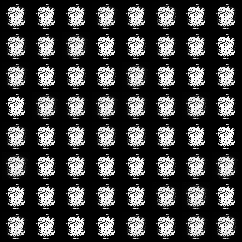



Train Epoch: 2 [0/60000 (0%)]	 Gen_Loss: 6.485231 Dis_loss: 0.026672
Train Epoch: 2 [12800/60000 (21%)]	 Gen_Loss: 8.076124 Dis_loss: 0.019636
Train Epoch: 2 [25600/60000 (43%)]	 Gen_Loss: 7.159905 Dis_loss: 0.009405
Train Epoch: 2 [38400/60000 (64%)]	 Gen_Loss: 6.515276 Dis_loss: 0.035623
Train Epoch: 2 [51200/60000 (85%)]	 Gen_Loss: 8.959745 Dis_loss: 0.018814
====> Epoch: 2 Average discriminator loss: 0.0252 Average generator loss: 6.9802
Sample of generated images


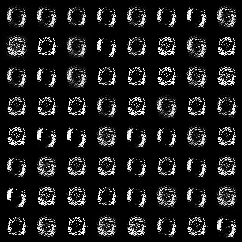



Train Epoch: 3 [0/60000 (0%)]	 Gen_Loss: 7.033178 Dis_loss: 0.049151
Train Epoch: 3 [12800/60000 (21%)]	 Gen_Loss: 5.728039 Dis_loss: 0.027079
Train Epoch: 3 [25600/60000 (43%)]	 Gen_Loss: 5.202518 Dis_loss: 0.037608
Train Epoch: 3 [38400/60000 (64%)]	 Gen_Loss: 6.230659 Dis_loss: 0.010654
Train Epoch: 3 [51200/60000 (85%)]	 Gen_Loss: 5.905013 Dis_loss: 0.013808
====> Epoch: 3 Average discriminator loss: 0.0233 Average generator loss: 6.2820
Sample of generated images


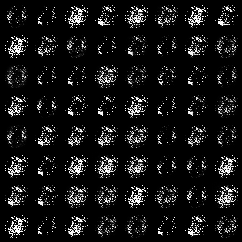



Train Epoch: 4 [0/60000 (0%)]	 Gen_Loss: 7.719502 Dis_loss: 0.016319
Train Epoch: 4 [12800/60000 (21%)]	 Gen_Loss: 7.440777 Dis_loss: 0.014302
Train Epoch: 4 [25600/60000 (43%)]	 Gen_Loss: 6.669631 Dis_loss: 0.010217
Train Epoch: 4 [38400/60000 (64%)]	 Gen_Loss: 6.987141 Dis_loss: 0.009234
Train Epoch: 4 [51200/60000 (85%)]	 Gen_Loss: 6.136816 Dis_loss: 0.041137
====> Epoch: 4 Average discriminator loss: 0.0145 Average generator loss: 7.2177
Sample of generated images


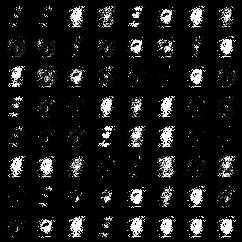



Train Epoch: 5 [0/60000 (0%)]	 Gen_Loss: 7.146859 Dis_loss: 0.018674
Train Epoch: 5 [12800/60000 (21%)]	 Gen_Loss: 9.624487 Dis_loss: 0.018264
Train Epoch: 5 [25600/60000 (43%)]	 Gen_Loss: 6.775587 Dis_loss: 0.038236
Train Epoch: 5 [38400/60000 (64%)]	 Gen_Loss: 8.741968 Dis_loss: 0.004513
Train Epoch: 5 [51200/60000 (85%)]	 Gen_Loss: 9.877242 Dis_loss: 0.017545
====> Epoch: 5 Average discriminator loss: 0.0220 Average generator loss: 7.8585
Sample of generated images


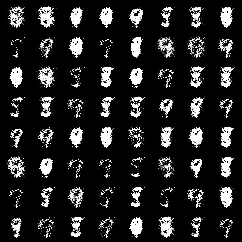



Train Epoch: 6 [0/60000 (0%)]	 Gen_Loss: 8.301338 Dis_loss: 0.057027
Train Epoch: 6 [12800/60000 (21%)]	 Gen_Loss: 8.470726 Dis_loss: 0.022094
Train Epoch: 6 [25600/60000 (43%)]	 Gen_Loss: 6.433237 Dis_loss: 0.019319
Train Epoch: 6 [38400/60000 (64%)]	 Gen_Loss: 8.651974 Dis_loss: 0.024475
Train Epoch: 6 [51200/60000 (85%)]	 Gen_Loss: 6.800057 Dis_loss: 0.021398
====> Epoch: 6 Average discriminator loss: 0.0268 Average generator loss: 8.0025
Sample of generated images


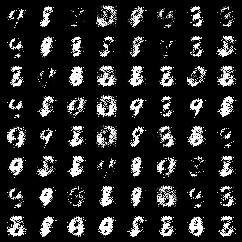



Train Epoch: 7 [0/60000 (0%)]	 Gen_Loss: 7.639527 Dis_loss: 0.019903
Train Epoch: 7 [12800/60000 (21%)]	 Gen_Loss: 6.866094 Dis_loss: 0.018977
Train Epoch: 7 [25600/60000 (43%)]	 Gen_Loss: 6.713640 Dis_loss: 0.013527
Train Epoch: 7 [38400/60000 (64%)]	 Gen_Loss: 8.039054 Dis_loss: 0.073514
Train Epoch: 7 [51200/60000 (85%)]	 Gen_Loss: 7.516505 Dis_loss: 0.018496
====> Epoch: 7 Average discriminator loss: 0.0259 Average generator loss: 7.5452
Sample of generated images


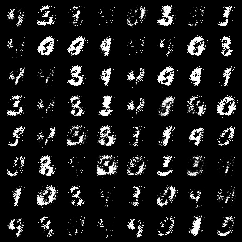



Train Epoch: 8 [0/60000 (0%)]	 Gen_Loss: 7.329626 Dis_loss: 0.019609
Train Epoch: 8 [12800/60000 (21%)]	 Gen_Loss: 7.735878 Dis_loss: 0.097600
Train Epoch: 8 [25600/60000 (43%)]	 Gen_Loss: 8.812089 Dis_loss: 0.043288
Train Epoch: 8 [38400/60000 (64%)]	 Gen_Loss: 6.275767 Dis_loss: 0.031193
Train Epoch: 8 [51200/60000 (85%)]	 Gen_Loss: 7.719027 Dis_loss: 0.022184
====> Epoch: 8 Average discriminator loss: 0.0393 Average generator loss: 7.6666
Sample of generated images


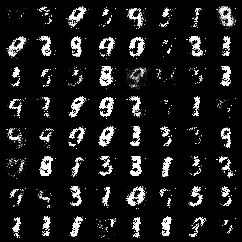



Train Epoch: 9 [0/60000 (0%)]	 Gen_Loss: 6.158885 Dis_loss: 0.015709
Train Epoch: 9 [12800/60000 (21%)]	 Gen_Loss: 7.119586 Dis_loss: 0.045831
Train Epoch: 9 [25600/60000 (43%)]	 Gen_Loss: 6.906488 Dis_loss: 0.021295
Train Epoch: 9 [38400/60000 (64%)]	 Gen_Loss: 7.601404 Dis_loss: 0.064746
Train Epoch: 9 [51200/60000 (85%)]	 Gen_Loss: 7.685721 Dis_loss: 0.049972
====> Epoch: 9 Average discriminator loss: 0.0524 Average generator loss: 7.1563
Sample of generated images


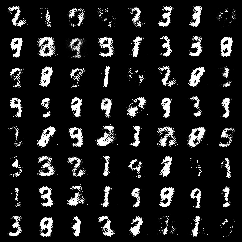



Train Epoch: 10 [0/60000 (0%)]	 Gen_Loss: 5.602568 Dis_loss: 0.157636
Train Epoch: 10 [12800/60000 (21%)]	 Gen_Loss: 6.309667 Dis_loss: 0.051782
Train Epoch: 10 [25600/60000 (43%)]	 Gen_Loss: 7.025006 Dis_loss: 0.067954
Train Epoch: 10 [38400/60000 (64%)]	 Gen_Loss: 8.424622 Dis_loss: 0.108930
Train Epoch: 10 [51200/60000 (85%)]	 Gen_Loss: 7.302390 Dis_loss: 0.100504
====> Epoch: 10 Average discriminator loss: 0.0767 Average generator loss: 6.8965
Sample of generated images


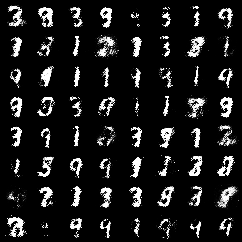



Train Epoch: 11 [0/60000 (0%)]	 Gen_Loss: 6.935304 Dis_loss: 0.038983
Train Epoch: 11 [12800/60000 (21%)]	 Gen_Loss: 7.487177 Dis_loss: 0.068311
Train Epoch: 11 [25600/60000 (43%)]	 Gen_Loss: 6.542898 Dis_loss: 0.050070
Train Epoch: 11 [38400/60000 (64%)]	 Gen_Loss: 8.228868 Dis_loss: 0.079320
Train Epoch: 11 [51200/60000 (85%)]	 Gen_Loss: 6.339321 Dis_loss: 0.121156
====> Epoch: 11 Average discriminator loss: 0.0937 Average generator loss: 6.7330
Sample of generated images


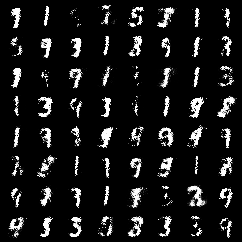



Train Epoch: 12 [0/60000 (0%)]	 Gen_Loss: 8.089297 Dis_loss: 0.050516
Train Epoch: 12 [12800/60000 (21%)]	 Gen_Loss: 5.622509 Dis_loss: 0.094222
Train Epoch: 12 [25600/60000 (43%)]	 Gen_Loss: 7.493729 Dis_loss: 0.069907
Train Epoch: 12 [38400/60000 (64%)]	 Gen_Loss: 6.220350 Dis_loss: 0.222973
Train Epoch: 12 [51200/60000 (85%)]	 Gen_Loss: 5.971444 Dis_loss: 0.068270
====> Epoch: 12 Average discriminator loss: 0.1248 Average generator loss: 6.5136
Sample of generated images


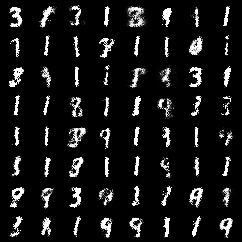



Train Epoch: 13 [0/60000 (0%)]	 Gen_Loss: 5.797563 Dis_loss: 0.189278
Train Epoch: 13 [12800/60000 (21%)]	 Gen_Loss: 6.018069 Dis_loss: 0.237676
Train Epoch: 13 [25600/60000 (43%)]	 Gen_Loss: 5.921916 Dis_loss: 0.083633
Train Epoch: 13 [38400/60000 (64%)]	 Gen_Loss: 5.567782 Dis_loss: 0.193428
Train Epoch: 13 [51200/60000 (85%)]	 Gen_Loss: 5.021475 Dis_loss: 0.240374
====> Epoch: 13 Average discriminator loss: 0.1804 Average generator loss: 5.4607
Sample of generated images


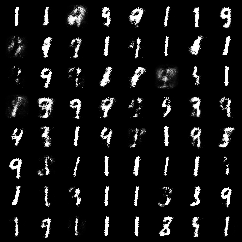



Train Epoch: 14 [0/60000 (0%)]	 Gen_Loss: 4.698773 Dis_loss: 0.145682
Train Epoch: 14 [12800/60000 (21%)]	 Gen_Loss: 5.031232 Dis_loss: 0.191831
Train Epoch: 14 [25600/60000 (43%)]	 Gen_Loss: 4.072648 Dis_loss: 0.256932
Train Epoch: 14 [38400/60000 (64%)]	 Gen_Loss: 4.265468 Dis_loss: 0.247131
Train Epoch: 14 [51200/60000 (85%)]	 Gen_Loss: 4.794939 Dis_loss: 0.251075
====> Epoch: 14 Average discriminator loss: 0.2216 Average generator loss: 4.7275
Sample of generated images


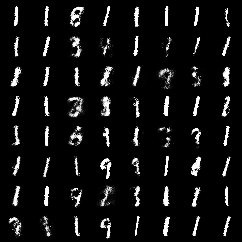



Train Epoch: 15 [0/60000 (0%)]	 Gen_Loss: 5.326750 Dis_loss: 0.194186
Train Epoch: 15 [12800/60000 (21%)]	 Gen_Loss: 4.180541 Dis_loss: 0.185408
Train Epoch: 15 [25600/60000 (43%)]	 Gen_Loss: 4.593530 Dis_loss: 0.326533
Train Epoch: 15 [38400/60000 (64%)]	 Gen_Loss: 3.552993 Dis_loss: 0.456443
Train Epoch: 15 [51200/60000 (85%)]	 Gen_Loss: 3.639171 Dis_loss: 0.315428
====> Epoch: 15 Average discriminator loss: 0.2688 Average generator loss: 4.3008
Sample of generated images


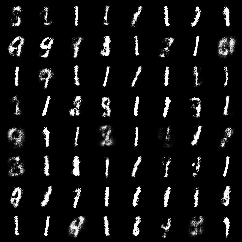



Train Epoch: 16 [0/60000 (0%)]	 Gen_Loss: 4.004827 Dis_loss: 0.217021
Train Epoch: 16 [12800/60000 (21%)]	 Gen_Loss: 4.290159 Dis_loss: 0.293053
Train Epoch: 16 [25600/60000 (43%)]	 Gen_Loss: 4.796341 Dis_loss: 0.323619
Train Epoch: 16 [38400/60000 (64%)]	 Gen_Loss: 4.753819 Dis_loss: 0.282898
Train Epoch: 16 [51200/60000 (85%)]	 Gen_Loss: 4.518889 Dis_loss: 0.260561
====> Epoch: 16 Average discriminator loss: 0.3063 Average generator loss: 4.2291
Sample of generated images


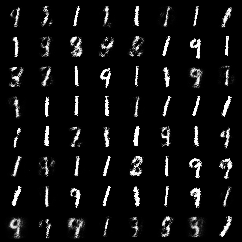



Train Epoch: 17 [0/60000 (0%)]	 Gen_Loss: 3.312376 Dis_loss: 0.317165
Train Epoch: 17 [12800/60000 (21%)]	 Gen_Loss: 4.487443 Dis_loss: 0.242434
Train Epoch: 17 [25600/60000 (43%)]	 Gen_Loss: 3.466868 Dis_loss: 0.495981
Train Epoch: 17 [38400/60000 (64%)]	 Gen_Loss: 3.844285 Dis_loss: 0.430104
Train Epoch: 17 [51200/60000 (85%)]	 Gen_Loss: 3.807496 Dis_loss: 0.416836
====> Epoch: 17 Average discriminator loss: 0.3323 Average generator loss: 4.0350
Sample of generated images


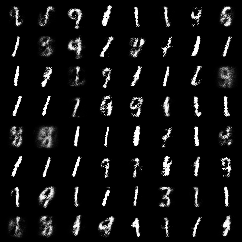



Train Epoch: 18 [0/60000 (0%)]	 Gen_Loss: 4.144702 Dis_loss: 0.298596
Train Epoch: 18 [12800/60000 (21%)]	 Gen_Loss: 4.232353 Dis_loss: 0.332310
Train Epoch: 18 [25600/60000 (43%)]	 Gen_Loss: 3.680722 Dis_loss: 0.359544
Train Epoch: 18 [38400/60000 (64%)]	 Gen_Loss: 3.352973 Dis_loss: 0.499895
Train Epoch: 18 [51200/60000 (85%)]	 Gen_Loss: 3.744720 Dis_loss: 0.367816
====> Epoch: 18 Average discriminator loss: 0.3784 Average generator loss: 3.8759
Sample of generated images


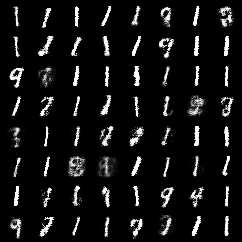



Train Epoch: 19 [0/60000 (0%)]	 Gen_Loss: 3.402735 Dis_loss: 0.484834
Train Epoch: 19 [12800/60000 (21%)]	 Gen_Loss: 3.807989 Dis_loss: 0.356378
Train Epoch: 19 [25600/60000 (43%)]	 Gen_Loss: 3.395515 Dis_loss: 0.455118
Train Epoch: 19 [38400/60000 (64%)]	 Gen_Loss: 4.135172 Dis_loss: 0.471799
Train Epoch: 19 [51200/60000 (85%)]	 Gen_Loss: 3.387593 Dis_loss: 0.331453
====> Epoch: 19 Average discriminator loss: 0.3906 Average generator loss: 3.8196
Sample of generated images


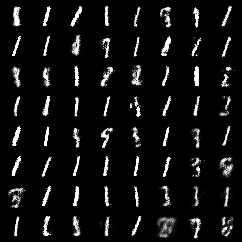



Train Epoch: 20 [0/60000 (0%)]	 Gen_Loss: 3.831674 Dis_loss: 0.307768
Train Epoch: 20 [12800/60000 (21%)]	 Gen_Loss: 3.654941 Dis_loss: 0.347806
Train Epoch: 20 [25600/60000 (43%)]	 Gen_Loss: 4.264937 Dis_loss: 0.451000
Train Epoch: 20 [38400/60000 (64%)]	 Gen_Loss: 3.432163 Dis_loss: 0.373574
Train Epoch: 20 [51200/60000 (85%)]	 Gen_Loss: 3.586428 Dis_loss: 0.379966
====> Epoch: 20 Average discriminator loss: 0.4070 Average generator loss: 3.6278
Sample of generated images


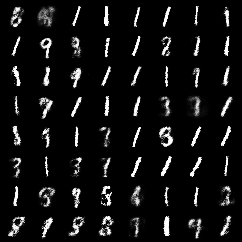



Train Epoch: 21 [0/60000 (0%)]	 Gen_Loss: 3.362770 Dis_loss: 0.415142
Train Epoch: 21 [12800/60000 (21%)]	 Gen_Loss: 4.041297 Dis_loss: 0.396286
Train Epoch: 21 [25600/60000 (43%)]	 Gen_Loss: 3.539296 Dis_loss: 0.362479
Train Epoch: 21 [38400/60000 (64%)]	 Gen_Loss: 3.994306 Dis_loss: 0.454652
Train Epoch: 21 [51200/60000 (85%)]	 Gen_Loss: 3.840947 Dis_loss: 0.267144
====> Epoch: 21 Average discriminator loss: 0.4173 Average generator loss: 3.5613
Sample of generated images


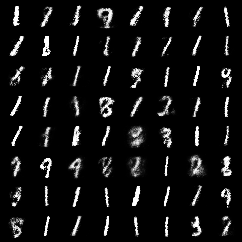



Train Epoch: 22 [0/60000 (0%)]	 Gen_Loss: 2.703513 Dis_loss: 0.459325
Train Epoch: 22 [12800/60000 (21%)]	 Gen_Loss: 3.360139 Dis_loss: 0.352474
Train Epoch: 22 [25600/60000 (43%)]	 Gen_Loss: 3.077470 Dis_loss: 0.307281
Train Epoch: 22 [38400/60000 (64%)]	 Gen_Loss: 3.274498 Dis_loss: 0.635971
Train Epoch: 22 [51200/60000 (85%)]	 Gen_Loss: 3.065243 Dis_loss: 0.393061
====> Epoch: 22 Average discriminator loss: 0.4160 Average generator loss: 3.4220
Sample of generated images


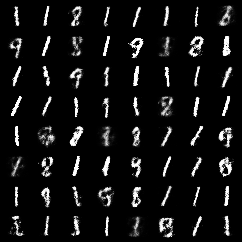



Train Epoch: 23 [0/60000 (0%)]	 Gen_Loss: 3.977672 Dis_loss: 0.495021
Train Epoch: 23 [12800/60000 (21%)]	 Gen_Loss: 3.159225 Dis_loss: 0.478718
Train Epoch: 23 [25600/60000 (43%)]	 Gen_Loss: 4.156964 Dis_loss: 0.370156
Train Epoch: 23 [38400/60000 (64%)]	 Gen_Loss: 3.520996 Dis_loss: 0.316843
Train Epoch: 23 [51200/60000 (85%)]	 Gen_Loss: 3.734533 Dis_loss: 0.250323
====> Epoch: 23 Average discriminator loss: 0.4259 Average generator loss: 3.4220
Sample of generated images


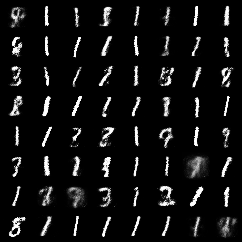



Train Epoch: 24 [0/60000 (0%)]	 Gen_Loss: 3.372488 Dis_loss: 0.417629
Train Epoch: 24 [12800/60000 (21%)]	 Gen_Loss: 3.369791 Dis_loss: 0.685175
Train Epoch: 24 [25600/60000 (43%)]	 Gen_Loss: 3.677688 Dis_loss: 0.502787
Train Epoch: 24 [38400/60000 (64%)]	 Gen_Loss: 2.784609 Dis_loss: 0.608365
Train Epoch: 24 [51200/60000 (85%)]	 Gen_Loss: 3.057900 Dis_loss: 0.330730
====> Epoch: 24 Average discriminator loss: 0.4485 Average generator loss: 3.3313
Sample of generated images


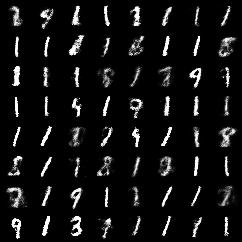



Train Epoch: 25 [0/60000 (0%)]	 Gen_Loss: 3.645303 Dis_loss: 0.369368
Train Epoch: 25 [12800/60000 (21%)]	 Gen_Loss: 3.397489 Dis_loss: 0.530025
Train Epoch: 25 [25600/60000 (43%)]	 Gen_Loss: 3.715940 Dis_loss: 0.400716
Train Epoch: 25 [38400/60000 (64%)]	 Gen_Loss: 2.372537 Dis_loss: 0.611385
Train Epoch: 25 [51200/60000 (85%)]	 Gen_Loss: 3.256316 Dis_loss: 0.449217
====> Epoch: 25 Average discriminator loss: 0.4526 Average generator loss: 3.2405
Sample of generated images


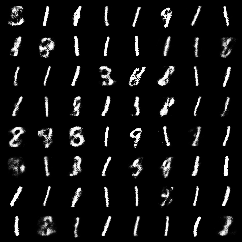



Train Epoch: 26 [0/60000 (0%)]	 Gen_Loss: 3.024219 Dis_loss: 0.426786
Train Epoch: 26 [12800/60000 (21%)]	 Gen_Loss: 3.372228 Dis_loss: 0.443470
Train Epoch: 26 [25600/60000 (43%)]	 Gen_Loss: 3.266002 Dis_loss: 0.372304
Train Epoch: 26 [38400/60000 (64%)]	 Gen_Loss: 2.828476 Dis_loss: 0.633217
Train Epoch: 26 [51200/60000 (85%)]	 Gen_Loss: 2.786913 Dis_loss: 0.668847
====> Epoch: 26 Average discriminator loss: 0.4659 Average generator loss: 3.1646
Sample of generated images


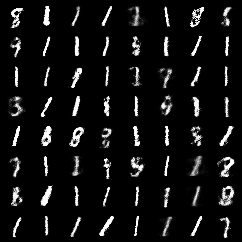



Train Epoch: 27 [0/60000 (0%)]	 Gen_Loss: 2.906343 Dis_loss: 0.462061
Train Epoch: 27 [12800/60000 (21%)]	 Gen_Loss: 3.098075 Dis_loss: 0.460158
Train Epoch: 27 [25600/60000 (43%)]	 Gen_Loss: 3.530100 Dis_loss: 0.340299
Train Epoch: 27 [38400/60000 (64%)]	 Gen_Loss: 3.126432 Dis_loss: 0.312955
Train Epoch: 27 [51200/60000 (85%)]	 Gen_Loss: 2.870696 Dis_loss: 0.406716
====> Epoch: 27 Average discriminator loss: 0.4757 Average generator loss: 3.1730
Sample of generated images


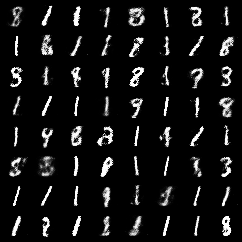



Train Epoch: 28 [0/60000 (0%)]	 Gen_Loss: 3.269122 Dis_loss: 0.372977
Train Epoch: 28 [12800/60000 (21%)]	 Gen_Loss: 3.454806 Dis_loss: 0.431265
Train Epoch: 28 [25600/60000 (43%)]	 Gen_Loss: 3.029486 Dis_loss: 0.395115
Train Epoch: 28 [38400/60000 (64%)]	 Gen_Loss: 2.686665 Dis_loss: 0.535482
Train Epoch: 28 [51200/60000 (85%)]	 Gen_Loss: 3.158933 Dis_loss: 0.397206
====> Epoch: 28 Average discriminator loss: 0.4814 Average generator loss: 3.0874
Sample of generated images


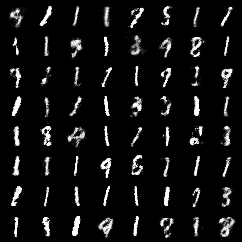



Train Epoch: 29 [0/60000 (0%)]	 Gen_Loss: 2.670729 Dis_loss: 0.789315
Train Epoch: 29 [12800/60000 (21%)]	 Gen_Loss: 3.444505 Dis_loss: 0.456191
Train Epoch: 29 [25600/60000 (43%)]	 Gen_Loss: 3.014124 Dis_loss: 0.516556
Train Epoch: 29 [38400/60000 (64%)]	 Gen_Loss: 3.041178 Dis_loss: 0.455687
Train Epoch: 29 [51200/60000 (85%)]	 Gen_Loss: 3.103901 Dis_loss: 0.590527
====> Epoch: 29 Average discriminator loss: 0.4838 Average generator loss: 3.0212
Sample of generated images


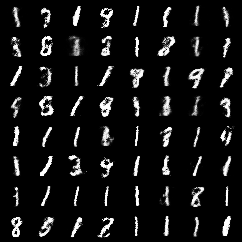



Train Epoch: 30 [0/60000 (0%)]	 Gen_Loss: 2.330533 Dis_loss: 0.531344
Train Epoch: 30 [12800/60000 (21%)]	 Gen_Loss: 2.817188 Dis_loss: 0.475016
Train Epoch: 30 [25600/60000 (43%)]	 Gen_Loss: 2.963098 Dis_loss: 0.378971
Train Epoch: 30 [38400/60000 (64%)]	 Gen_Loss: 3.433311 Dis_loss: 0.500463
Train Epoch: 30 [51200/60000 (85%)]	 Gen_Loss: 3.124007 Dis_loss: 0.507468
====> Epoch: 30 Average discriminator loss: 0.4819 Average generator loss: 2.9881
Sample of generated images


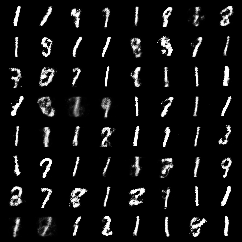



Train Epoch: 31 [0/60000 (0%)]	 Gen_Loss: 3.536757 Dis_loss: 0.384741
Train Epoch: 31 [12800/60000 (21%)]	 Gen_Loss: 2.638493 Dis_loss: 0.534453
Train Epoch: 31 [25600/60000 (43%)]	 Gen_Loss: 3.080760 Dis_loss: 0.374913
Train Epoch: 31 [38400/60000 (64%)]	 Gen_Loss: 2.370810 Dis_loss: 0.574959
Train Epoch: 31 [51200/60000 (85%)]	 Gen_Loss: 3.073831 Dis_loss: 0.490641
====> Epoch: 31 Average discriminator loss: 0.4947 Average generator loss: 3.0159
Sample of generated images


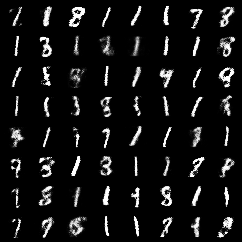



Train Epoch: 32 [0/60000 (0%)]	 Gen_Loss: 2.457849 Dis_loss: 0.509187
Train Epoch: 32 [12800/60000 (21%)]	 Gen_Loss: 3.026444 Dis_loss: 0.305022
Train Epoch: 32 [25600/60000 (43%)]	 Gen_Loss: 3.009330 Dis_loss: 0.453152
Train Epoch: 32 [38400/60000 (64%)]	 Gen_Loss: 3.077926 Dis_loss: 0.396851
Train Epoch: 32 [51200/60000 (85%)]	 Gen_Loss: 2.691331 Dis_loss: 0.567295
====> Epoch: 32 Average discriminator loss: 0.4939 Average generator loss: 2.9519
Sample of generated images


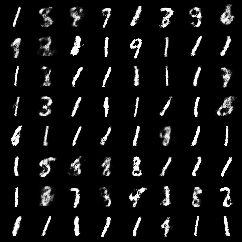



Train Epoch: 33 [0/60000 (0%)]	 Gen_Loss: 3.208763 Dis_loss: 0.704881
Train Epoch: 33 [12800/60000 (21%)]	 Gen_Loss: 3.059463 Dis_loss: 0.584261
Train Epoch: 33 [25600/60000 (43%)]	 Gen_Loss: 3.084224 Dis_loss: 0.417295
Train Epoch: 33 [38400/60000 (64%)]	 Gen_Loss: 3.233102 Dis_loss: 0.446998
Train Epoch: 33 [51200/60000 (85%)]	 Gen_Loss: 2.792894 Dis_loss: 0.440398
====> Epoch: 33 Average discriminator loss: 0.5023 Average generator loss: 2.9878
Sample of generated images


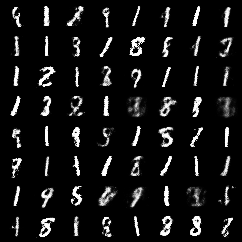



Train Epoch: 34 [0/60000 (0%)]	 Gen_Loss: 2.742326 Dis_loss: 0.515515
Train Epoch: 34 [12800/60000 (21%)]	 Gen_Loss: 2.696914 Dis_loss: 0.636496
Train Epoch: 34 [25600/60000 (43%)]	 Gen_Loss: 2.713152 Dis_loss: 0.779655
Train Epoch: 34 [38400/60000 (64%)]	 Gen_Loss: 2.964800 Dis_loss: 0.501369
Train Epoch: 34 [51200/60000 (85%)]	 Gen_Loss: 2.510859 Dis_loss: 0.481360
====> Epoch: 34 Average discriminator loss: 0.5014 Average generator loss: 2.9363
Sample of generated images


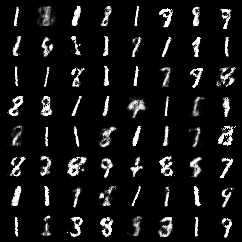



Train Epoch: 35 [0/60000 (0%)]	 Gen_Loss: 3.031550 Dis_loss: 0.431250
Train Epoch: 35 [12800/60000 (21%)]	 Gen_Loss: 2.776441 Dis_loss: 0.518816
Train Epoch: 35 [25600/60000 (43%)]	 Gen_Loss: 2.972552 Dis_loss: 0.660440
Train Epoch: 35 [38400/60000 (64%)]	 Gen_Loss: 3.128749 Dis_loss: 0.402079
Train Epoch: 35 [51200/60000 (85%)]	 Gen_Loss: 2.875069 Dis_loss: 0.590766
====> Epoch: 35 Average discriminator loss: 0.5075 Average generator loss: 2.8705
Sample of generated images


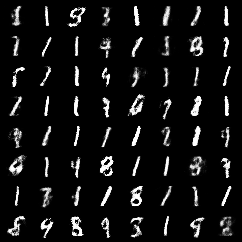



Train Epoch: 36 [0/60000 (0%)]	 Gen_Loss: 2.624507 Dis_loss: 0.525731
Train Epoch: 36 [12800/60000 (21%)]	 Gen_Loss: 2.763299 Dis_loss: 0.365735
Train Epoch: 36 [25600/60000 (43%)]	 Gen_Loss: 2.693526 Dis_loss: 0.331806
Train Epoch: 36 [38400/60000 (64%)]	 Gen_Loss: 2.208061 Dis_loss: 0.565215
Train Epoch: 36 [51200/60000 (85%)]	 Gen_Loss: 2.718428 Dis_loss: 0.506610
====> Epoch: 36 Average discriminator loss: 0.5093 Average generator loss: 2.7852
Sample of generated images


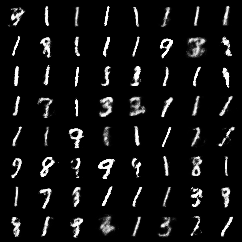



Train Epoch: 37 [0/60000 (0%)]	 Gen_Loss: 2.860583 Dis_loss: 0.702489
Train Epoch: 37 [12800/60000 (21%)]	 Gen_Loss: 2.796655 Dis_loss: 0.519465
Train Epoch: 37 [25600/60000 (43%)]	 Gen_Loss: 2.916241 Dis_loss: 0.481579
Train Epoch: 37 [38400/60000 (64%)]	 Gen_Loss: 2.546074 Dis_loss: 0.624852
Train Epoch: 37 [51200/60000 (85%)]	 Gen_Loss: 3.005409 Dis_loss: 0.519385
====> Epoch: 37 Average discriminator loss: 0.5163 Average generator loss: 2.7423
Sample of generated images


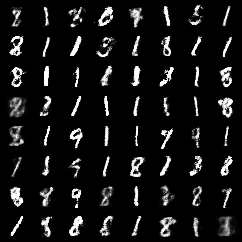



Train Epoch: 38 [0/60000 (0%)]	 Gen_Loss: 2.583706 Dis_loss: 0.409190
Train Epoch: 38 [12800/60000 (21%)]	 Gen_Loss: 3.447029 Dis_loss: 0.516603
Train Epoch: 38 [25600/60000 (43%)]	 Gen_Loss: 2.830485 Dis_loss: 0.546478
Train Epoch: 38 [38400/60000 (64%)]	 Gen_Loss: 2.651207 Dis_loss: 0.475400
Train Epoch: 38 [51200/60000 (85%)]	 Gen_Loss: 2.763996 Dis_loss: 0.400128
====> Epoch: 38 Average discriminator loss: 0.5056 Average generator loss: 2.8842
Sample of generated images


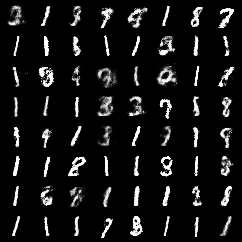



Train Epoch: 39 [0/60000 (0%)]	 Gen_Loss: 2.976812 Dis_loss: 0.514735
Train Epoch: 39 [12800/60000 (21%)]	 Gen_Loss: 3.092660 Dis_loss: 0.497110
Train Epoch: 39 [25600/60000 (43%)]	 Gen_Loss: 3.159801 Dis_loss: 0.484057
Train Epoch: 39 [38400/60000 (64%)]	 Gen_Loss: 3.012891 Dis_loss: 0.682879
Train Epoch: 39 [51200/60000 (85%)]	 Gen_Loss: 2.963560 Dis_loss: 0.437384
====> Epoch: 39 Average discriminator loss: 0.5046 Average generator loss: 2.9118
Sample of generated images


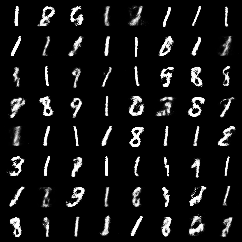



Train Epoch: 40 [0/60000 (0%)]	 Gen_Loss: 2.739357 Dis_loss: 0.477165
Train Epoch: 40 [12800/60000 (21%)]	 Gen_Loss: 2.948024 Dis_loss: 0.597778
Train Epoch: 40 [25600/60000 (43%)]	 Gen_Loss: 2.645596 Dis_loss: 0.476011
Train Epoch: 40 [38400/60000 (64%)]	 Gen_Loss: 2.517099 Dis_loss: 0.514167
Train Epoch: 40 [51200/60000 (85%)]	 Gen_Loss: 2.796680 Dis_loss: 0.555849
====> Epoch: 40 Average discriminator loss: 0.5121 Average generator loss: 2.8350
Sample of generated images


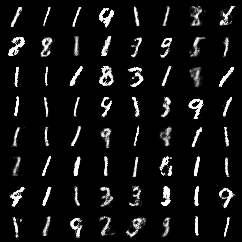



Train Epoch: 41 [0/60000 (0%)]	 Gen_Loss: 2.839489 Dis_loss: 0.363204
Train Epoch: 41 [12800/60000 (21%)]	 Gen_Loss: 2.762856 Dis_loss: 0.432457
Train Epoch: 41 [25600/60000 (43%)]	 Gen_Loss: 2.779694 Dis_loss: 0.649741
Train Epoch: 41 [38400/60000 (64%)]	 Gen_Loss: 2.770468 Dis_loss: 0.559722
Train Epoch: 41 [51200/60000 (85%)]	 Gen_Loss: 2.565415 Dis_loss: 0.475683
====> Epoch: 41 Average discriminator loss: 0.5183 Average generator loss: 2.7440
Sample of generated images


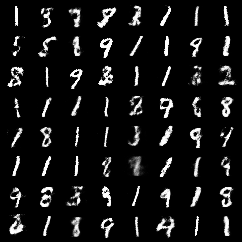



Train Epoch: 42 [0/60000 (0%)]	 Gen_Loss: 2.755152 Dis_loss: 0.491287
Train Epoch: 42 [12800/60000 (21%)]	 Gen_Loss: 2.312455 Dis_loss: 0.528268
Train Epoch: 42 [25600/60000 (43%)]	 Gen_Loss: 2.821968 Dis_loss: 0.578201
Train Epoch: 42 [38400/60000 (64%)]	 Gen_Loss: 2.602072 Dis_loss: 0.464219
Train Epoch: 42 [51200/60000 (85%)]	 Gen_Loss: 2.785132 Dis_loss: 0.418461
====> Epoch: 42 Average discriminator loss: 0.5188 Average generator loss: 2.7038
Sample of generated images


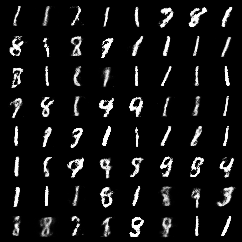



Train Epoch: 43 [0/60000 (0%)]	 Gen_Loss: 2.541965 Dis_loss: 0.558523
Train Epoch: 43 [12800/60000 (21%)]	 Gen_Loss: 2.863686 Dis_loss: 0.460147
Train Epoch: 43 [25600/60000 (43%)]	 Gen_Loss: 2.678980 Dis_loss: 0.540190
Train Epoch: 43 [38400/60000 (64%)]	 Gen_Loss: 2.492008 Dis_loss: 0.427071
Train Epoch: 43 [51200/60000 (85%)]	 Gen_Loss: 3.218846 Dis_loss: 0.411669
====> Epoch: 43 Average discriminator loss: 0.5178 Average generator loss: 2.6834
Sample of generated images


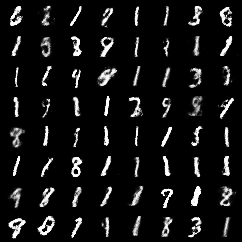



Train Epoch: 44 [0/60000 (0%)]	 Gen_Loss: 2.629117 Dis_loss: 0.409081
Train Epoch: 44 [12800/60000 (21%)]	 Gen_Loss: 2.994381 Dis_loss: 0.537881
Train Epoch: 44 [25600/60000 (43%)]	 Gen_Loss: 3.040121 Dis_loss: 0.530229
Train Epoch: 44 [38400/60000 (64%)]	 Gen_Loss: 2.704333 Dis_loss: 0.549515
Train Epoch: 44 [51200/60000 (85%)]	 Gen_Loss: 2.867083 Dis_loss: 0.559848
====> Epoch: 44 Average discriminator loss: 0.5189 Average generator loss: 2.7024
Sample of generated images


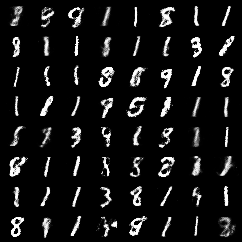



Train Epoch: 45 [0/60000 (0%)]	 Gen_Loss: 2.986463 Dis_loss: 0.493074
Train Epoch: 45 [12800/60000 (21%)]	 Gen_Loss: 2.792854 Dis_loss: 0.431948
Train Epoch: 45 [25600/60000 (43%)]	 Gen_Loss: 2.612488 Dis_loss: 0.583182
Train Epoch: 45 [38400/60000 (64%)]	 Gen_Loss: 2.623112 Dis_loss: 0.442869
Train Epoch: 45 [51200/60000 (85%)]	 Gen_Loss: 3.181376 Dis_loss: 0.489398
====> Epoch: 45 Average discriminator loss: 0.5169 Average generator loss: 2.7592
Sample of generated images


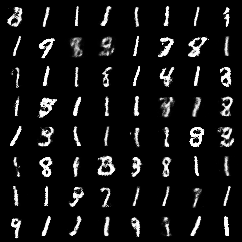



Train Epoch: 46 [0/60000 (0%)]	 Gen_Loss: 2.872749 Dis_loss: 0.515608
Train Epoch: 46 [12800/60000 (21%)]	 Gen_Loss: 3.028754 Dis_loss: 0.520348
Train Epoch: 46 [25600/60000 (43%)]	 Gen_Loss: 2.581958 Dis_loss: 0.530209
Train Epoch: 46 [38400/60000 (64%)]	 Gen_Loss: 2.466716 Dis_loss: 0.586391
Train Epoch: 46 [51200/60000 (85%)]	 Gen_Loss: 2.631278 Dis_loss: 0.503366
====> Epoch: 46 Average discriminator loss: 0.5239 Average generator loss: 2.7540
Sample of generated images


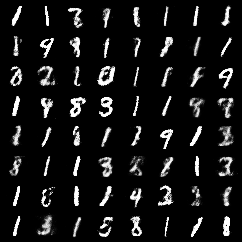



Train Epoch: 47 [0/60000 (0%)]	 Gen_Loss: 3.116040 Dis_loss: 0.510193
Train Epoch: 47 [12800/60000 (21%)]	 Gen_Loss: 2.868259 Dis_loss: 0.428096
Train Epoch: 47 [25600/60000 (43%)]	 Gen_Loss: 2.435253 Dis_loss: 0.535253
Train Epoch: 47 [38400/60000 (64%)]	 Gen_Loss: 2.387471 Dis_loss: 0.708753
Train Epoch: 47 [51200/60000 (85%)]	 Gen_Loss: 2.522312 Dis_loss: 0.451075
====> Epoch: 47 Average discriminator loss: 0.5244 Average generator loss: 2.7240
Sample of generated images


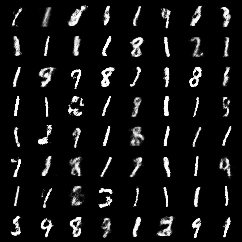



Train Epoch: 48 [0/60000 (0%)]	 Gen_Loss: 2.951196 Dis_loss: 0.450686
Train Epoch: 48 [12800/60000 (21%)]	 Gen_Loss: 2.783640 Dis_loss: 0.547611
Train Epoch: 48 [25600/60000 (43%)]	 Gen_Loss: 2.824298 Dis_loss: 0.496708
Train Epoch: 48 [38400/60000 (64%)]	 Gen_Loss: 2.614272 Dis_loss: 0.548421
Train Epoch: 48 [51200/60000 (85%)]	 Gen_Loss: 2.501742 Dis_loss: 0.566575
====> Epoch: 48 Average discriminator loss: 0.5226 Average generator loss: 2.6820
Sample of generated images


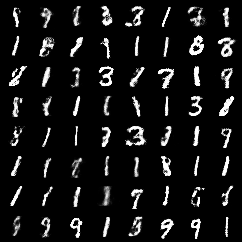



Train Epoch: 49 [0/60000 (0%)]	 Gen_Loss: 2.823315 Dis_loss: 0.488227
Train Epoch: 49 [12800/60000 (21%)]	 Gen_Loss: 2.952439 Dis_loss: 0.459108
Train Epoch: 49 [25600/60000 (43%)]	 Gen_Loss: 2.376453 Dis_loss: 0.538460
Train Epoch: 49 [38400/60000 (64%)]	 Gen_Loss: 2.471753 Dis_loss: 0.467422
Train Epoch: 49 [51200/60000 (85%)]	 Gen_Loss: 2.692912 Dis_loss: 0.476481
====> Epoch: 49 Average discriminator loss: 0.5217 Average generator loss: 2.6726
Sample of generated images


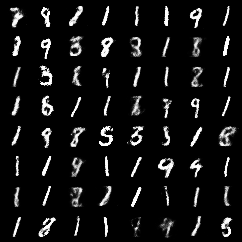



Train Epoch: 50 [0/60000 (0%)]	 Gen_Loss: 2.851738 Dis_loss: 0.606322
Train Epoch: 50 [12800/60000 (21%)]	 Gen_Loss: 2.535806 Dis_loss: 0.570677
Train Epoch: 50 [25600/60000 (43%)]	 Gen_Loss: 2.595271 Dis_loss: 0.576679
Train Epoch: 50 [38400/60000 (64%)]	 Gen_Loss: 2.552659 Dis_loss: 0.559578
Train Epoch: 50 [51200/60000 (85%)]	 Gen_Loss: 2.790549 Dis_loss: 0.376979
====> Epoch: 50 Average discriminator loss: 0.5269 Average generator loss: 2.6762
Sample of generated images


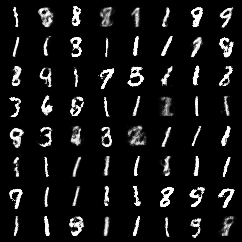

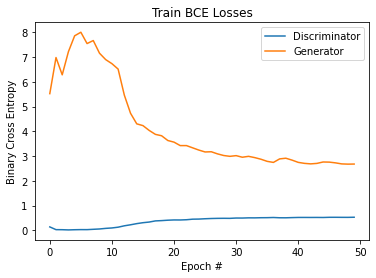

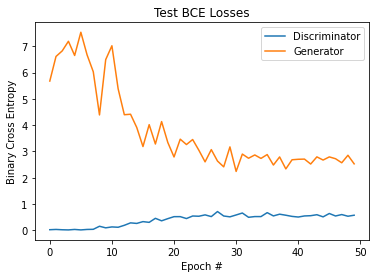

In [6]:
# train and test gan
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()


### Write-up 

1.   By inspection, the discriminator has lower losses.
2.   As the number of epoch increases, the image gets clearer. By observation, the images from VAE and DAE are blurred, however, GAN has the sharpest images with clear numbers. This can be explained by the functions of generator and discriminator. Discriminator is responsible for detecting fake images via training and generator is devoted to producing better images.
3. I do think that using more images generated by GAN to train a CNN classifier can improve the classification accuracy. GAN extends existing datasets with more realistic characteristics, which can provide high-quality training data and thus boost the accuracy. There could be minor improvement with images generated by VAE and DAE, but not as strong as GAN. This is concluded based on observations from Question 2.

In [7]:
# !wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
# from colab_pdf import colab_pdf
# colab_pdf('cs480_winter22_asst5_gan_skeleton.ipynb')